In [70]:
using QuantumOptics
using QuantumBayesian
using PyPlot
using Statistics
import Base: *

# Single Qubit Evolution Tests

**Justin Dressel**, 12/6/2016 <br />
*Institute for Quantum Studies, Chapman University*

Benchmark various integration algorithms for a single qubit damped Rabi oscillation, for comparison with the DifferentialEquations package tested in a separate notebook.

## Basic Definitions

### Qubit Hilbert space

In [3]:
q = SpinBasis(1//2)
z = spinup(q)
zm = spindown(q)
y = (z + im*zm)/sqrt(2)
x = (z + zm)/sqrt(2)
Z = dm(z)
Y = dm(y)
X = dm(x)

Operator(dim=2x2)
  basis: Spin(1/2)
 0.5+0.0im  0.5+0.0im
 0.5+0.0im  0.5+0.0im

### Global Constants

In [4]:
Ω  = 2π        # Rabi frequency
τ = 3.0        # Measurement collapse timescale
Γ = 1/(2τ)     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 6τ)  # Time duration of simulation;
η = 1.0        # Measurement efficiency

dt = 1e-2      # Simulation timestep (coarse to show method precision);

### Common Trajectory and Plotting Code

In [65]:
# SuperOperator Vector Operations

function superket(x)
    basis = GenericBasis(length(x))
    X = Ket(basis)
    X.data = reshape(x.data, length(x.data), 1)[:]
    return (X, (x.basis_l, x.basis_r))
end

function unsuperket(X, basis)
    d = Int(sqrt(length(X)))
    d^2 == length(X) || error("Not a superket")
    op = SparseOperator(basis[1], basis[2])
    op.data = reshape(X.data, d, d)
    return op
end

function *(a::SuperOperator{B1,B2}, b::Ket{B3}) where {B1<:Tuple{Basis,Basis},B2<:Tuple{Basis,Basis},B3<:Basis}
    ket = Ket(b.basis)
    ket.data = a.data*b.data
    return ket
end

* (generic function with 604 methods)

In [66]:
# Initial conditions (matrix and superket)
init = Z
sinit, basis = superket(init)

# Bloch expectation values (matrix and superket)
fs = collect(ρ -> 2real(expect(ρ, l) - 0.5) for l in [X, Y, Z]);
sfs = collect(ρ -> 2real(expect(unsuperket(ρ, (Z.basis_l, Z.basis_r)),l) - 0.5) for l in [X, Y, Z])

# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title; readout=false, n=1)
    figure(1)
    if n==1
        out = trajectory(inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = trajectory(inc, init, T, fs..., dt=dt)
        plot(out[1].t,out[1],label=L"$x$",color="r")
        plot(out[2].t,out[2],label=L"$y$",color="g")
        plot(out[3].t,out[3],label=L"$z$",color="b")
        plot(out[3].t,out[1].^2 .+ out[2].^2 .+ out[3].^2,label=L"$x^2 + y^2 + z^2$",color="purple")
    else
        out = ensemble(1, inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = ensemble(n, inc, init, T, fs..., dt=dt)
        m1 = Statistics.mean(out[1]; dims=2)[:]
        m2 = Statistics.mean(out[2]; dims=2)[:]
        m3 = Statistics.mean(out[3]; dims=2)[:]
        s1 = Statistics.std(out[1]; dims=2)[:]
        s2 = Statistics.std(out[2]; dims=2)[:]
        s3 = Statistics.std(out[3]; dims=2)[:]
        
        plot(out[1].t,m1,label=L"$x$",color="r")
        plot(out[2].t,m2,label=L"$y$",color="g")
        plot(out[3].t,m3,label=L"$z$",color="b")
        fill_between(out[1].t, m1-s1, m1+s1, color="r", alpha=0.2, antialiased=true)
        fill_between(out[2].t, m2-s2, m2+s2, color="g", alpha=0.2, antialiased=true)
        fill_between(out[3].t, m3-s3, m3+s3, color="b", alpha=0.2, antialiased=true)
    end
    ax = gca()
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    show()
    if readout
        figure(2)
        if n==1
            plot(out[4].t,out[4],label=L"$r_z$",color="k")
        else
            m4 = Statistics.mean(out[4]; dims=2)[:]
            s4 = Statistics.std(out[4]; dims=2)[:]
            plot(out[4].t,m4,label=L"$r_z$",color="k")
            fill_between(out[4].t, m4-s4, m4+s4, color="k", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t (2\pi/\Omega)$")
        ylabel("Stochastic readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

## Time-independent Rabi Hamiltonian

In [55]:
# Hamiltonian
H(t) = 2exp(-(t-3τ)^2/2)/sqrt(2π)*(Ω/2)*Y
# Measurement dephasing
DM = [sqrt(Γ/2)*Z]
# Stochastic monitoring (unit efficiency)
SM = [(Z, τ, η)];

### Coherent (Hamiltonian) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.019454002380371094
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 92525.94735036031
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


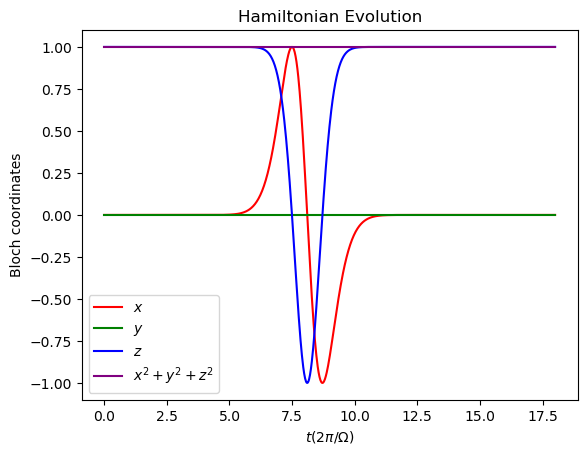

  0.170619 seconds (296.47 k allocations: 17.786 MiB, 15.55% gc time)


In [8]:
solve(ham(dt, H), init, dt, T, fs, "Hamiltonian Evolution")

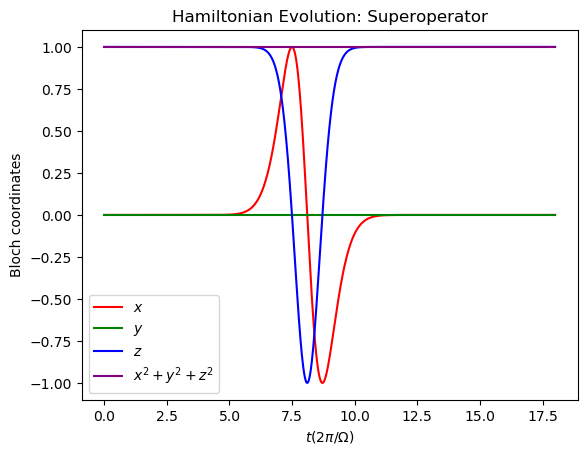

  0.085633 seconds (276.80 k allocations: 19.934 MiB, 41.77% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.07512903213500977
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 23958.78063177136
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [9]:
solve(sham(dt, H), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

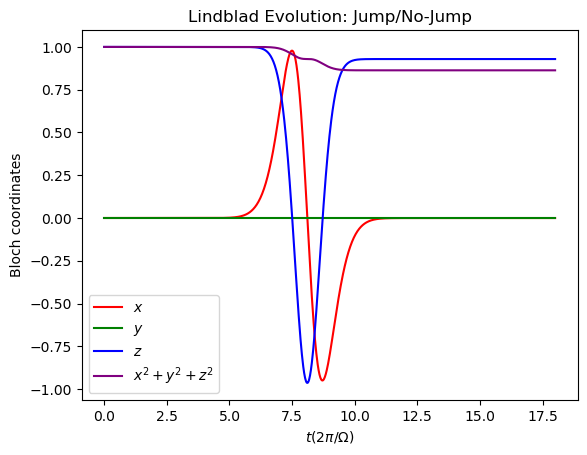

  0.048770 seconds (257.02 k allocations: 20.560 MiB, 45.89% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.0484619140625
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 37142.56926952141
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [10]:
solve(lind(dt, H, clist=DM), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

  0.174607 seconds (

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.040393829345703125
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 44561.26168665596
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


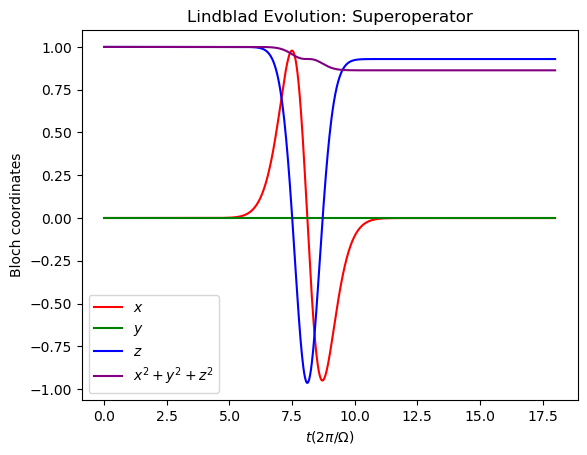

543.94 k allocations: 44.972 MiB, 12.45% gc time)


In [8]:
solve(slind(dt, H, clist=DM), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

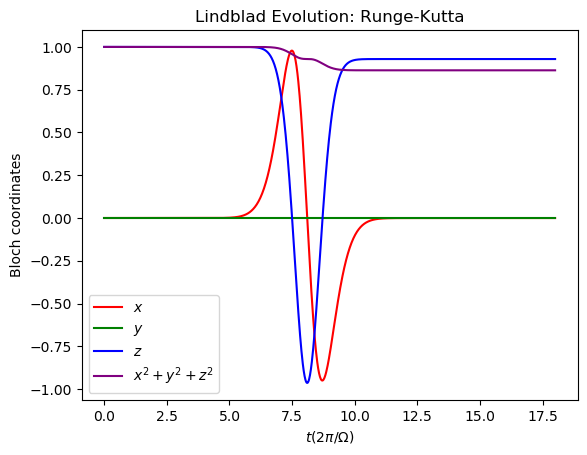

  0.089005 seconds (649.81 k allocations: 34.995 MiB, 35.46% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Time elapsed: 
│   elapsed = 0.08820414543151855
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 20407.20411941993
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:644


In [179]:
solve(lind_rk4(dt, H, clist=DM), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

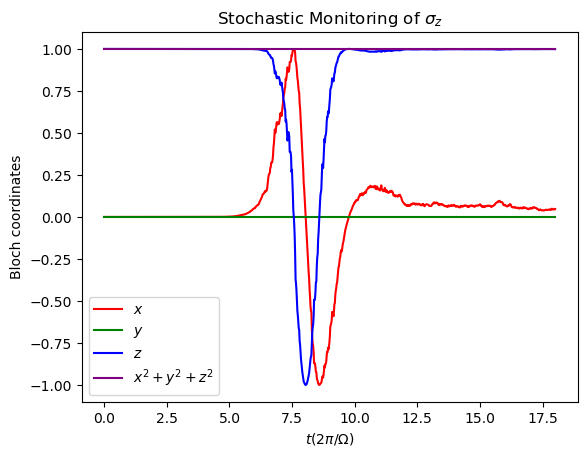

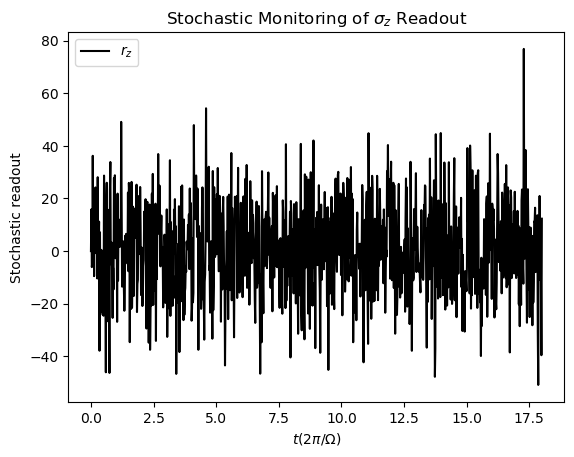

  0.058762 seconds (287.04 k allocations: 20.333 MiB, 31.13% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:626
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.057398080825805664
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 31359.933539637375
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:644


In [180]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$", readout=true)

(Note: no parallelization performed here to benchmark serial execution of an ensemble simulation. Plotted is the mean with shaded standard deviation behind.)

┌ Info: Trajectories: 
│   n = 2500
│   , steps each:  = , steps each: 
│   N = 1799
│   , points each:  = , points each: 
│   min(N, points) = 1000
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:551
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:554


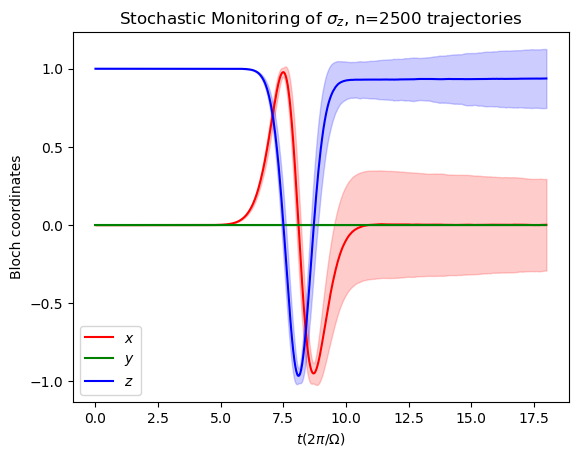

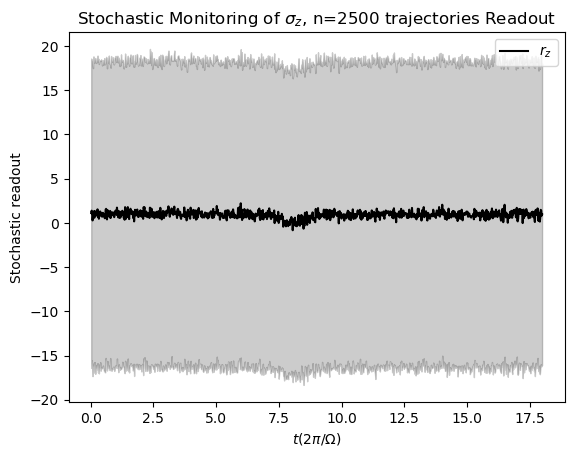

112.980839 seconds (717.14 M allocations: 49.619 GiB, 7.22% gc time)


┌ Info: Time elapsed: 
│   elapsed = 112.93136596679688
│    s, Steps:  =  s, Steps: 
│   steps = 2500000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 22137.339600895546
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:572


In [67]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$, n=2500 trajectories", readout=true, n=2500)

## Time-dependent Rabi Pulse

In [9]:
# Hamiltonian
f(t::Float64) = 2exp(-(t-3τ)^2/2)/sqrt(2π)
h(t::Float64) = f(t)*(Ω/2)*Y;

### Coherent (Hamiltonian) Evolution

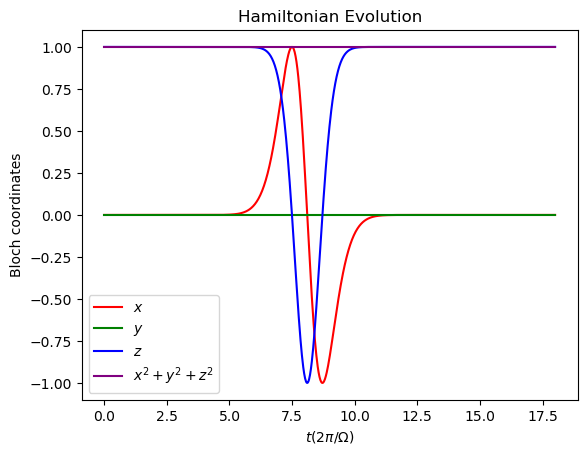

  0.054880 seconds (123.31 k allocations: 8.712 MiB, 50.30% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.04817795753479004
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 37361.48421610012
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [10]:
solve(ham(dt, h), init, dt, T, fs, "Hamiltonian Evolution")

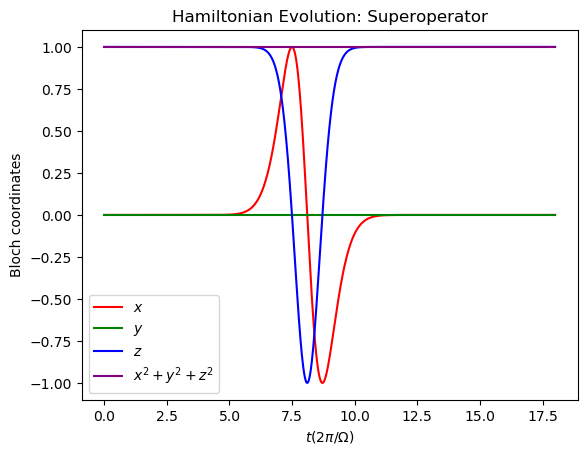

  0.027158 seconds (264.59 k allocations: 19.277 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.026797056198120117
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 67171.55745362338
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [11]:
solve(sham(dt, h), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

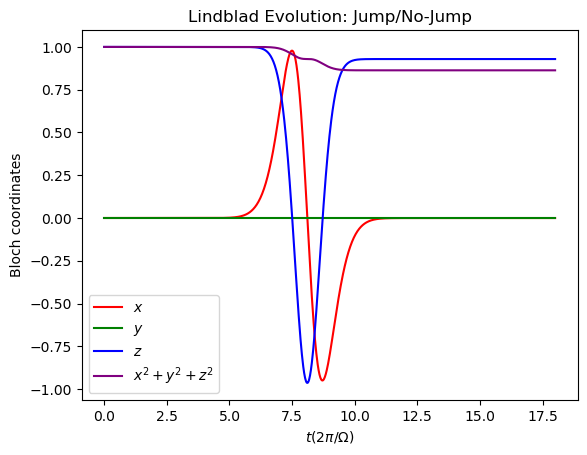

  0.060787 seconds (257.02 k allocations: 20.560 MiB, 45.08% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.06043219566345215
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 29785.44764489823
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [12]:
solve(lind(dt, h, clist=DM), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

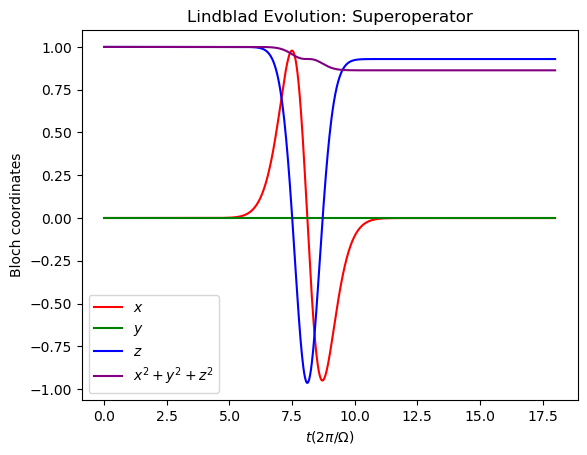

  0.047269 seconds (358.57 k allocations: 35.242 MiB, 31.28% gc time)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.04694199562072754
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 38345.19551625535
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [20]:
solve(slind(dt, h, clist=DM), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Time elapsed: 
│   elapsed = 0.0424959659576416
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 42356.961641822025
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


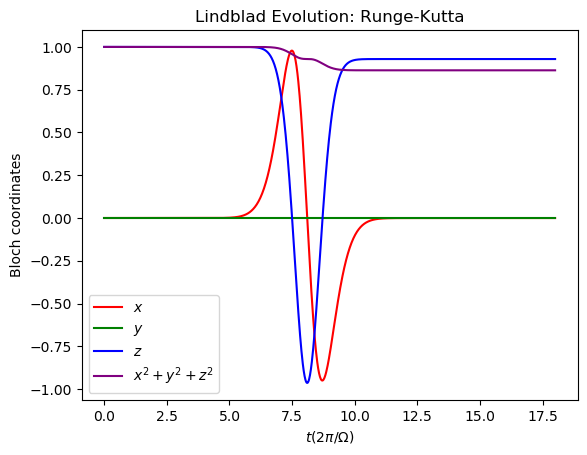

  0.043082 seconds (649.96 k allocations: 35.007 MiB)


In [21]:
solve(lind_rk4(dt, h, clist=DM), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

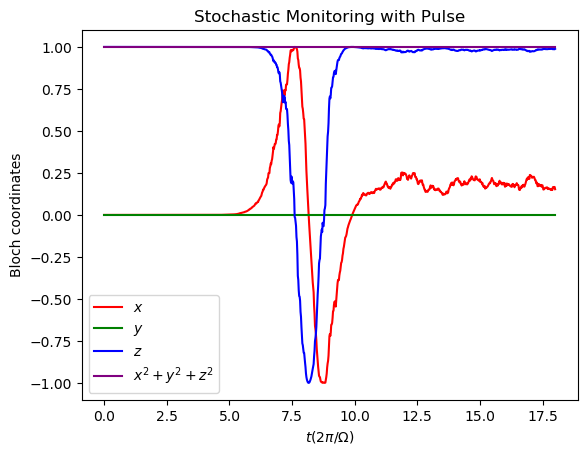

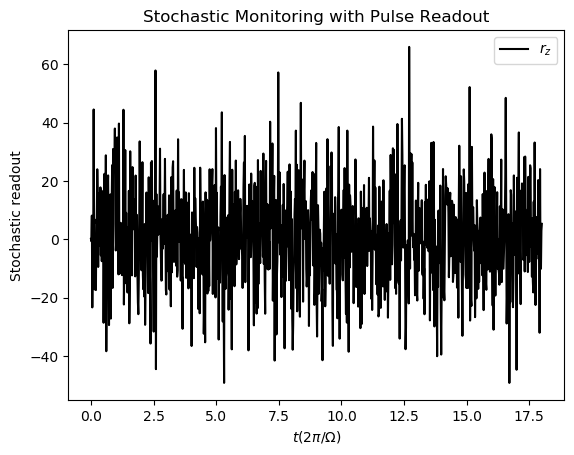

  0.081322 seconds (287.04 k allocations: 20.333 MiB)


┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:627
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:628
┌ Info: Time elapsed: 
│   elapsed = 0.08085489273071289
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 22262.10361808156
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:645


In [22]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse", readout=true)

┌ Info: Trajectories: 
│   n = 2500
│   , steps each:  = , steps each: 
│   N = 1799
│   , points each:  = , points each: 
│   min(N, points) = 1000
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:551
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:554


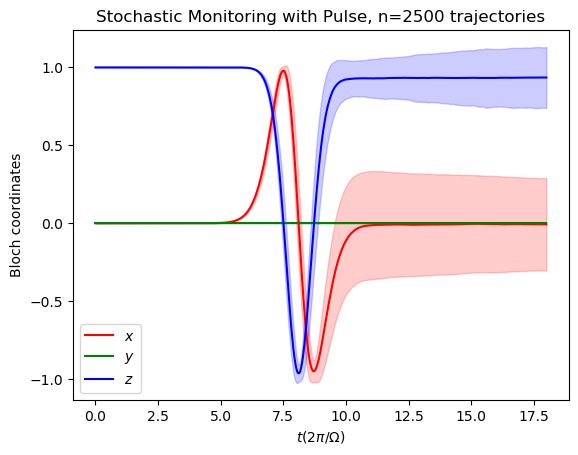

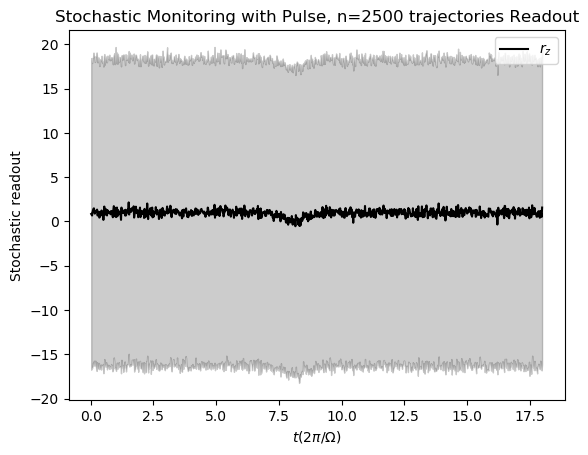

111.370638 seconds (717.14 M allocations: 49.619 GiB, 8.22% gc time)


┌ Info: Time elapsed: 
│   elapsed = 111.30157017707825
│    s, Steps:  =  s, Steps: 
│   steps = 2500000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 22461.498036573583
└ @ QuantumBayesian /Users/luke/Dropbox/Work/Summer 2020/QuantumBayesian.jl/src/QuantumBayesian.jl:572


In [68]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse, n=2500 trajectories", readout=true, n=2500)

## Version Information

In [33]:
versioninfo()

Julia Version 1.4.1
Commit 381693d3df* (2020-04-14 17:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i7-7660U CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
